In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

# Neural Networks
import tensorflow
import keras
from keras.applications import MobileNet

# AWS
import boto3

# Model
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


## Downloading Data from a Bucket

In [2]:
!ls ~/.aws

credentials


In [3]:
s3 = boto3.resource("s3")

In [22]:
# Looking at all buckets
for bucket in s3.buckets.all():
    print(bucket)

bucket = s3.Bucket("firearm-image-classification")

s3.Bucket(name='firearm-image-classification')
s3.Bucket(name='jefferson-demo-0106')


In [2]:
# prints the contents of bucket
for s3_file in bucket.objects.all():
    print(s3_file.key)

In [3]:
# Downloading all Objects in the bucket to current directory
!aws s3 sync s3://firearm-image-classification .

## Data Generator

In [4]:
# Alters pictures
image_gen = keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-06,
    rotation_range=0.0,
    width_shift_range=0.0,
    height_shift_range=0.0,
    shear_range=0.0,
    zoom_range=0.0,
    channel_shift_range=0.0,
    fill_mode='nearest',
    cval=0.0,
    horizontal_flip=False,
    vertical_flip=False,
    rescale=1./255,
    preprocessing_function=None,
    data_format=None)

In [5]:
# Loading Images
image_gen = image_gen.flow_from_directory(
    "Data",
    target_size=(300, 300),
    color_mode='rgb',
    classes=None,
    class_mode='categorical',
    batch_size=1596,
    shuffle=True,
    seed=123,
    save_to_dir=None,
    save_prefix='',
    save_format='png',
    follow_links=False,
    interpolation='nearest')

Found 1541 images belonging to 6 classes.


In [6]:
# Data Classes
image_gen.class_indices  # From directory (the way it was labeled)

{'Assault_Rifles': 0,
 'Camera_Feed': 1,
 'Handguns': 2,
 'Holstered_Guns': 3,
 'People_Holding_Handguns': 4,
 'People_Holding_Rifles': 5}

In [7]:
image_gen.image_shape

(300, 300, 3)

## Images and Lables

In [8]:
# split images and labels
images, labels = next(image_gen)
images.shape, labels.shape

((1541, 300, 300, 3), (1541, 6))

## Showing Images

Classes:{'Assault_Rifles': 0, 'Camera_Feed': 1, 'Handguns': 2, 'Holstered_Guns': 3, 'People_Holding_Handguns': 4, 'People_Holding_Rifles': 5}
[1. 0. 0. 0. 0. 0.]


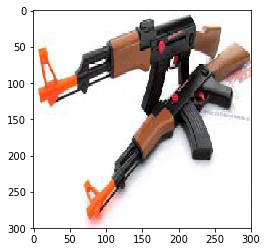

In [9]:
def show_image(n):
    
    print(f"Classes:{image_gen.class_indices}")
    plt.imshow(images[n])
    print(labels[n])
    
show_image(80)

## Train and Test Split

In [10]:
X_model, X_test, y_model, y_test = train_test_split(images, labels, test_size=0.2, random_state=41)
X_model.shape, X_test.shape, y_model.shape, y_test.shape

((1232, 300, 300, 3), (309, 300, 300, 3), (1232, 6), (309, 6))

## Validation Set

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X_model, y_model, test_size=0.2, random_state=41)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((985, 300, 300, 3), (247, 300, 300, 3), (985, 6), (247, 6))

In [12]:
# Convenlutional Neural Network Model
cnn = keras.models.Sequential()

cnn.add(keras.layers.Conv2D(64, (3, 3),
                      activation='relu',
                      input_shape=(300, 300,  3),
                      padding='SAME'))
cnn.add(keras.layers.MaxPooling2D((2, 2)))

cnn.add(keras.layers.Conv2D(32, (3, 3), activation='relu', padding='SAME'))
cnn.add(keras.layers.MaxPooling2D((2, 2)))

cnn.add(keras.layers.Conv2D(32, (3, 3), activation='relu', padding='SAME'))

cnn.add(keras.layers.Flatten())
cnn.add(keras.layers.Dense(32, activation='relu'))
cnn.add(keras.layers.Dense(6, activation='softmax'))

# Producing Neural Network
cnn.compile(loss='binary_crossentropy',  # Loss function
            optimizer="sgd",  # Gradient Descent
            metrics=['acc'])  # Accuracy score

In [13]:
saving_weights = keras.callbacks.ModelCheckpoint(
    'weights.{epoch:02d}-{loss:.2f}.hdf5',
    monitor='loss', verbose=0, save_best_only=False,
    save_weights_only=False, mode='auto', period=10
)

In [14]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='loss', factor=0.1, patience=20,
    verbose=0, mode='auto', min_lr=0)

In [15]:
# If there are problems with input data then it will stop it
nan_problem = keras.callbacks.TerminateOnNaN()

In [16]:
# Stops Epochs when modeling stops to improve
early_stop = keras.callbacks.EarlyStopping(
    monitor='loss', min_delta=0, patience=20,
    verbose=0, mode='auto')

In [17]:
print(cnn.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 300, 300, 64)      1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 150, 150, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 150, 150, 32)      18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 75, 75, 32)        9248      
_________________________________________________________________
flatten_1 (Flatten)          (None, 180000)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)               

In [ ]:
cnn1 = cnn.fit(X_train,
               y_train,
               validation_data=(X_val, y_val),
               epochs=1_000,
               batch_size=100,
               callbacks=[early_stop, nan_problem, reduce_lr, saving_weights])

Train on 985 samples, validate on 247 samples
Epoch 1/1000
985/985 [==============================] - 112s 114ms/step - loss: 0.4173 - acc: 0.8347 - val_loss: 0.4159 - val_acc: 0.8360
Epoch 2/1000
985/985 [==============================] - 113s 114ms/step - loss: 0.4119 - acc: 0.8398 - val_loss: 0.4113 - val_acc: 0.8381
Epoch 3/1000
985/985 [==============================] - 112s 113ms/step - loss: 0.4069 - acc: 0.8416 - val_loss: 0.4076 - val_acc: 0.8394
Epoch 4/1000
985/985 [==============================] - 112s 114ms/step - loss: 0.4053 - acc: 0.8420 - val_loss: 0.4058 - val_acc: 0.8333
Epoch 5/1000
985/985 [==============================] - 114s 116ms/step - loss: 0.0096 - acc: 0.9966 - val_loss: 0.4695 - val_acc: 0.8893
Epoch 258/1000
985/985 [==============================] - 114s 116ms/step - loss: 0.0121 - acc: 0.9939 - val_loss: 0.4578 - val_acc: 0.8900
Epoch 259/1000
985/985 [==============================] - 113s 115ms/step - loss: 0.0099 - acc: 0.9961 - val_loss: 0.4479 - 

In [27]:
results_train = cnn.evaluate(X_train, y_train)
results_test = cnn.evaluate(X_test, y_test)
print(results_train, results_test)

309/309 [==============================] - 9s 28ms/step
[0.005672667402925376, 0.9979695677757263] [0.4223171498590303, 0.8872708082199097]


## Saving Model

In [21]:
# File path names
file_path_model = "entire_model.hdf5"
file_path_weights = "weights.hdf5"

# Saving
cnn.save(file_path_model)
cnn.save_weights(file_path_weights)

In [23]:
cnn.load_weights(file_path_weights)

## Transfer Learning

In [28]:
conv_base = MobileNet(weights='imagenet', 
                      include_top=True)

17227776/17225924 [==============================] - 0s 0us/step


In [29]:
conv_base.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

In [52]:
def extract_features(directory, sample_amount):
    features = np.zeros(shape=(sample_amount, 2, 2, 512)) 
    labels = np.zeros(shape=(sample_amount))
    
    generator = keras.preprocessing.image.ImageDataGenerator().flow_from_directory(
        directory="Data", target_size=(224, 224), 
        batch_size=10, 
        class_mode='binary')
    i=0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch 
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i = i + 1
        if i * batch_size >= sample_amount:
            break
    return features, labels

In [53]:
# You should be able to divide sample_amount by batch_size
train_features, train_labels = extract_features(X_train, 540) 
validation_features, validation_labels = extract_features(X_val, 200) 
test_features, test_labels = extract_features(X_test, 180)

train_features = np.reshape(train_features, (540, 2 * 2 * 512))
validation_features = np.reshape(validation_features, (200, 2 * 2 * 512))
test_features = np.reshape(test_features, (180, 2 * 2 * 512))

NameError: name 'sample_amount' is not defined

In [ ]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=2*2*512))
model.add(layers.Dense(1, activation='softmax'))

model.compile(optimizer=optimizers.RMSprop(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=20,
                    batch_size=10,
                    validation_data=(validation_features, validation_labels))

In [ ]:
results_test = model.evaluate(test_features, test_labels)
results_test

In [ ]:
train_acc = history.history['acc']
val_acc = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epch = range(1, len(train_acc) + 1)
plt.plot(epch, train_acc, 'g.', label='Training Accuracy')
plt.plot(epch, val_acc, 'g', label='Validation acc')
plt.title('Accuracy')
plt.legend()
plt.figure()
plt.plot(epch, train_loss, 'r.', label='Training loss')
plt.plot(epch, val_loss, 'r', label='Validation loss')
plt.title('Loss')
plt.legend()
plt.show()